In [1]:
!git clone https://github.com/phan-le-phu/Plate_detect_and_recognize

Cloning into 'Plate_detect_and_recognize'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 195 (delta 5), reused 0 (delta 0), pack-reused 180
Receiving objects: 100% (195/195), 53.60 MiB | 31.76 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [2]:
cd Plate_detect_and_recognize/

/content/Plate_detect_and_recognize


In [3]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
import glob
import math

#### Extract license plate from sample _Plate_examples/germany_car_plate.jpg_  

In [4]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [5]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


In [6]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin=256):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

#test_image_path = "test_2.jpg"
test_image_path = "/content/xe-may-bien-ngu-quy-1602131030738310515689.jpg"
vehicle, LpImg,cor = get_plate(test_image_path)

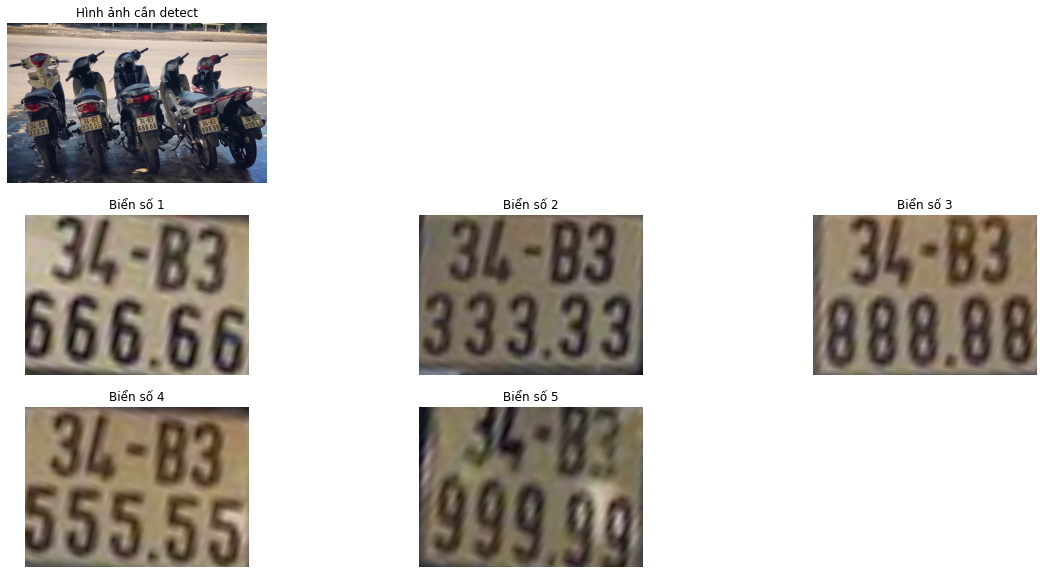

In [7]:
nrows = math.ceil(len(LpImg) / 3) + 1
fig3 = plt.figure(figsize=(20, 10))
ax = fig3.add_subplot(nrows, 3, 1)
ax.axis("off")
ax.set_title("Hình ảnh cần detect")
implot = plt.imshow(vehicle)
for i in range(len(LpImg)):
  ax = fig3.add_subplot(nrows, 3, 4 + i)
  ax.axis("off")
  ax.set_title(f"Biển số {i + 1}")
  plt.imshow(LpImg[i])


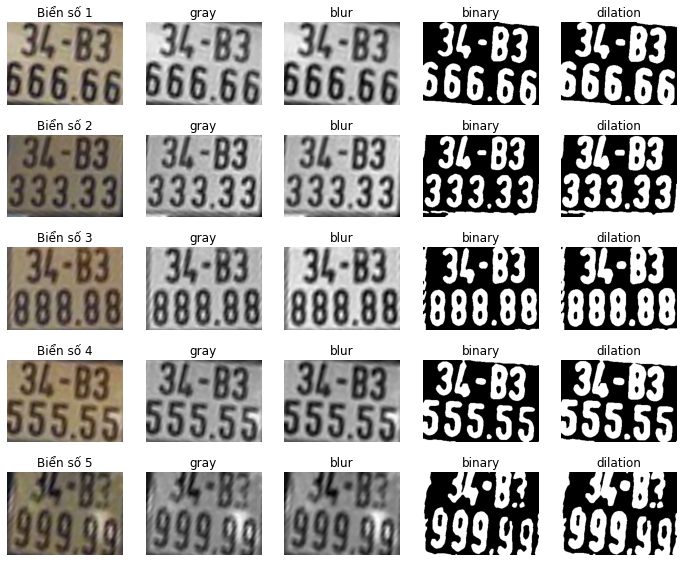

In [13]:
binary_images = []
fig = plt.figure(figsize=(12, 10))

for i in range(len(LpImg)):
      # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(LpImg[i], alpha=(255.0))
    
    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    
    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    binary_images.append(thre_mor)

    plot_image = [plate_image, gray, blur, binary,thre_mor]
    plot_name = [f"Biển số {i + 1}","gray","blur","binary","dilation"]

    for k in range(len(plot_image)):
        ax = fig.add_subplot(len(LpImg), 5, i * len(plot_image) + k + 1)
        ax.axis("off")
        ax.set_title(plot_name[k])
        plt.imshow(plot_image[k], cmap=None if k == 0 else 'gray')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

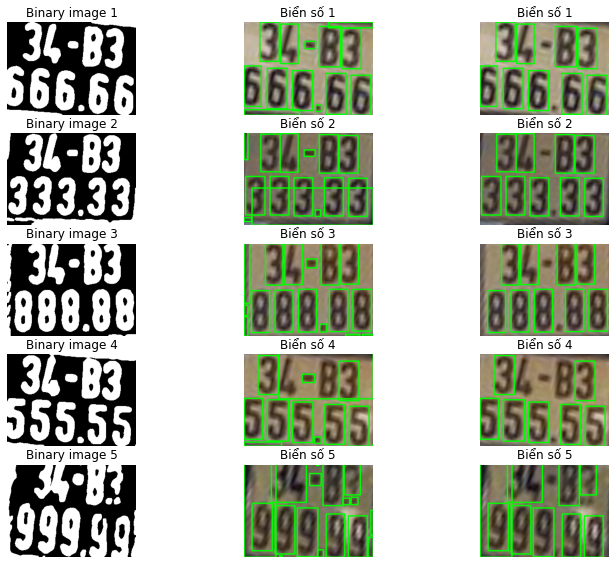

In [54]:
plate_numbers = []

# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

fig = plt.figure(figsize=(12, 20))

for i in range(len(LpImg)):
  cont, _  = cv2.findContours(binary_images[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # creat a copy version "test_roi" of plat_image to draw bounding box
  test_roi_1 = LpImg[i].copy()
  test_roi_2 = LpImg[i].copy()

  # Initialize a list which will be used to append charater image
  crop_characters = []

  # define standard width and height of character
  digit_w, digit_h = 30, 60

  for c in sort_contours(cont):
      (x, y, w, h) = cv2.boundingRect(c)
      cv2.rectangle(test_roi_1, (x, y), (x + w, y + h), (0, 255, 0), 2)

      ratio = h/w
      if 1<=ratio<=5: # Only select contour with defined ratio
          if h/LpImg[i].shape[0]>=0.3: # Select contour which has the height larger than 50% of the plate
              # Draw bounding box arroung digit number
              cv2.rectangle(test_roi_2, (x, y), (x + w, y + h), (0, 255, 0), 2)

              # Sperate number and gibe prediction
              curr_num = binary_images[i][y:y+h,x:x+w]
              curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
              _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
              crop_characters.append(curr_num)
  plate_numbers.append(crop_characters)


  ax = fig.add_subplot(len(LpImg) * 2, 3, (i + 1) * 3 + 1)
  ax.set_title(f"Binary image {i + 1}")
  ax.axis("off")
  plt.imshow(binary_images[i], cmap='gray')
  ax = fig.add_subplot(len(LpImg) * 2, 3, (i + 1) * 3 + 2)
  ax.set_title(f"Biển số {i + 1}")
  ax.axis("off")
  plt.imshow(test_roi_1)
  ax = fig.add_subplot(len(LpImg) * 2, 3, (i + 1) * 3 + 3)
  ax.set_title(f"Biển số {i + 1}")
  ax.axis("off")
  plt.imshow(test_roi_2)     

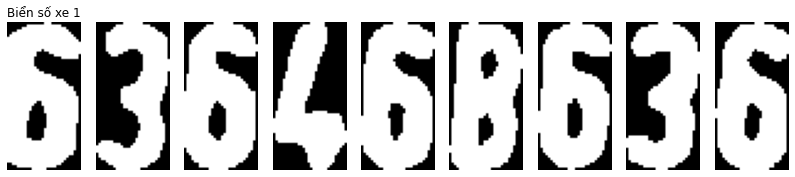

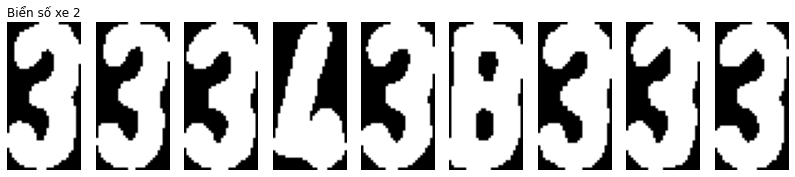

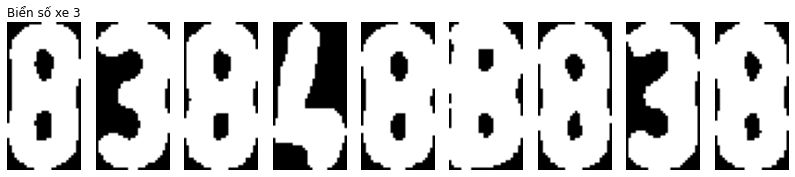

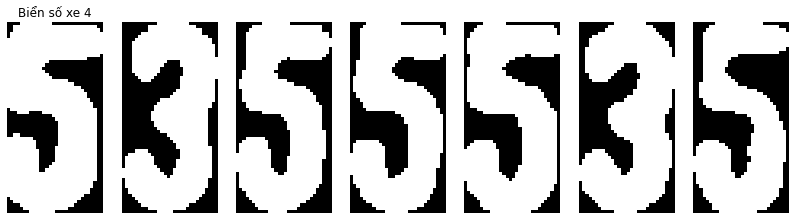

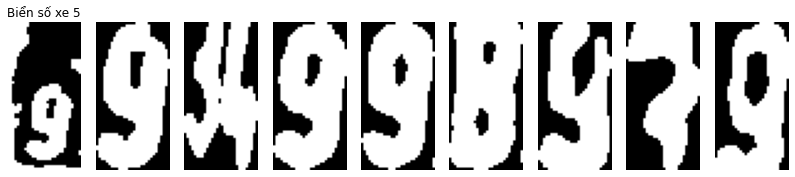

In [58]:
for i in range(len(plate_numbers)):
  crop_characters = plate_numbers[i]
  fig = plt.figure(figsize=(14,10))
  grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

  for k in range(len(crop_characters)):
      ax =fig.add_subplot(grid[k])
      if k == 0:
        ax.set_title(f"Biển số xe {i + 1}")
      plt.axis(False)
      plt.imshow(crop_characters[k],cmap="gray")
#plt.savefig("segmented_leter.png",dpi=300)    

# The end!